# AirBnB Challenge Submission

Input: AirBnB listings

Output: Whether the listing will be booked on an evening one month in the future. This evening is listing-dependent (not static to all listings)

## Part 0: Imports

In [3]:
# import sys
# !{sys.executable} -m pip install h2o

import h2o

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Part 1: Acquire and Load Data

In [4]:
h2o.init(ip="127.0.0.1" , port = 5151, max_mem_size="14g")

# reading in the original dataset included in this notebook
data_path = "https://phillytalent.s3.amazonaws.com/projects/airbnb/data/TH_data_challenge_complete.csv"
data = h2o.import_file(data_path, destination_frame = "airbnb_challenge_raw")
data = data.as_data_frame()

# reading in dataset downloaded from AWS for the challenge
# airbnb = h2o.import_file('TH_data_challenge_d4.csv', destination_frame = "airbnb_raw")
# airbnb = airbnb.as_data_frame()

Checking whether there is an H2O instance running at http://127.0.0.1:5151 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmpk996200k
  JVM stdout: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmpk996200k\h2o_Logan_started_from_python.out
  JVM stderr: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmpk996200k\h2o_Logan_started_from_python.err
  Server is running at http://127.0.0.1:5151
Connecting to H2O server at http://127.0.0.1:5151 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_Logan_qt9ooc
H2O cluster total nodes:,1
H2O cluster free memory:,12.44 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
## Ignore all kdt-related features for now
data.drop(columns = ['kdt_score', 'r_kdt_listing_views_0_6_avg_n100', 'r_kdt_n_active_n100',
                     'r_kdt_n_available_n100', 'r_kdt_m_effective_daily_price_n100_p50',
                     'r_kdt_m_effective_daily_price_available_n100_p50', 
                     'r_kdt_m_effective_daily_price_booked_n100_p50'],
         inplace=True)

## Part 2: Clean the Data

##### We will start by removing variables that are redundant or which we have no intention of using

In [6]:
for col in data.columns:
    print("'" + col + "',")

'dim_is_requested',
'ds_night',
'ds',
'id_listing_anon',
'id_user_anon',
'm_effective_daily_price',
'm_pricing_cleaning_fee',
'dim_market',
'dim_lat',
'dim_lng',
'dim_room_type',
'dim_person_capacity',
'dim_is_instant_bookable',
'm_checkouts',
'm_reviews',
'days_since_last_booking',
'cancel_policy',
'image_quality_score',
'm_total_overall_rating',
'm_professional_pictures',
'dim_has_wireless_internet',
'ds_night_day_of_week',
'ds_night_day_of_year',
'ds_checkin_gap',
'ds_checkout_gap',
'occ_occupancy_plus_minus_7_ds_night',
'occ_occupancy_plus_minus_14_ds_night',
'occ_occupancy_trailing_90_ds',
'm_minimum_nights',
'm_maximum_nights',
'price_booked_most_recent',
'p2_p3_click_through_score',
'p3_inquiry_score',
'listing_m_listing_views_2_6_ds_night_decay',
'general_market_m_unique_searchers_0_6_ds_night',
'general_market_m_contacts_0_6_ds_night',
'general_market_m_reservation_requests_0_6_ds_night',
'general_market_m_is_booked_0_6_ds_night',
'm_available_listings_ds_night',


In [7]:
try:
    data.drop(columns = [
        'ds_night',        # Redundant with day of week, day of year
        'ds',              # Redundant with day of week, day of year
        'id_listing_anon', # Of possible clerical use, we will ignore it for now
        'id_user_anon'     # No possible use    
    ], inplace=True)
except KeyError:
    pass

##### Next, we ensure that each remaining feature is formatted consistently and correctly (appropriate data type, no holes)

In [8]:
for col, dtype in zip(data.columns, data.dtypes):
    print(col.rjust(50, ' '), " ", dtype)

                                  dim_is_requested   bool
                           m_effective_daily_price   float64
                            m_pricing_cleaning_fee   float64
                                        dim_market   object
                                           dim_lat   float64
                                           dim_lng   float64
                                     dim_room_type   object
                               dim_person_capacity   int64
                           dim_is_instant_bookable   bool
                                       m_checkouts   float64
                                         m_reviews   float64
                           days_since_last_booking   float64
                                     cancel_policy   int64
                               image_quality_score   float64
                            m_total_overall_rating   float64
                           m_professional_pictures   float64
                         dim_has_wir

We would probably prefer *ds_night_day_of_the_week*, as well as a few other features, to be a categorical variables

In [9]:
for col in ['ds_night_day_of_week',
            'cancel_policy',
            'dim_has_wireless_internet']:
    data[col] = data[col].astype('category')

In [12]:
for col, dtype in zip(data.columns, data.dtypes):
    print(col.rjust(50, ' '), " ", dtype)

                                  dim_is_requested   bool
                           m_effective_daily_price   float64
                            m_pricing_cleaning_fee   float64
                                        dim_market   object
                                           dim_lat   float64
                                           dim_lng   float64
                                     dim_room_type   object
                               dim_person_capacity   int64
                           dim_is_instant_bookable   bool
                                       m_checkouts   float64
                                         m_reviews   float64
                           days_since_last_booking   float64
                                     cancel_policy   category
                               image_quality_score   float64
                            m_total_overall_rating   float64
                           m_professional_pictures   float64
                         dim_has_

##### Resolve inssues with missing data:

In [10]:
for col in data.columns:
    numNan = data[col].isna().sum()
    if numNan > 0 and numNan >= 5000:
        print("{} : {} NaNs".format(col.rjust(42, ' '), numNan))
print("="*100)
for col in data.columns:
    numNan = data[col].isna().sum()
    if numNan > 0 and numNan < 5000:
        print("{} : {} NaNs".format(col.rjust(42, ' '), numNan))

                   days_since_last_booking : 37836 NaNs
                       image_quality_score : 14011 NaNs
       occ_occupancy_plus_minus_7_ds_night : 20727 NaNs
      occ_occupancy_plus_minus_14_ds_night : 20652 NaNs
              occ_occupancy_trailing_90_ds : 10218 NaNs
                  price_booked_most_recent : 37836 NaNs
                 p2_p3_click_through_score : 127110 NaNs
                          p3_inquiry_score : 129290 NaNs
                               m_checkouts : 187 NaNs
                                 m_reviews : 187 NaNs
                    m_total_overall_rating : 187 NaNs
                   m_professional_pictures : 187 NaNs
                            ds_checkin_gap : 2221 NaNs
                           ds_checkout_gap : 2221 NaNs
                          m_minimum_nights : 2221 NaNs
                          m_maximum_nights : 2221 NaNs
listing_m_listing_views_2_6_ds_night_decay : 2346 NaNs


In [11]:
# Drop columns with very high frequencies of NaNs
try:
    data.drop(columns = [
        'occ_occupancy_plus_minus_7_ds_night',
        'occ_occupancy_plus_minus_14_ds_night',
        'occ_occupancy_trailing_90_ds',
        'price_booked_most_recent',
        'p2_p3_click_through_score',
        'p3_inquiry_score'
#         'r_kdt_m_effective_daily_price_booked_n100_p50' ## Removed in previous step
    ], inplace = True)
except KeyError:
    pass
data.shape

(184279, 29)

The feature *days_since_last_booking* has a lot of null values, but we don't necessarily want to drop this variable. In a vast majority of cases, a null value is meaningfully verifying that the listing has no history of checkouts. In all other cases, the value is nonsense and these rows can justifiably be dropped.

In [12]:
null_bookings  = data['days_since_last_booking'].isnull()
no_checkouts   = data['m_checkouts'] == 0
some_checkouts = data['m_checkouts'] > 0

print("Before filter:")
print(data[null_bookings &   no_checkouts].shape)
print(data[null_bookings & some_checkouts].shape)
print("="*30)

condition = data[null_bookings & some_checkouts]
data.drop(condition.index, inplace=True)

null_bookings  = data['days_since_last_booking'].isnull()
no_checkouts   = data['m_checkouts'] == 0
some_checkouts = data['m_checkouts'] > 0

print("After filter:")
print(data[null_bookings &   no_checkouts].shape)
print(data[null_bookings & some_checkouts].shape)

Before filter:
(37075, 29)
(741, 29)
After filter:
(37075, 29)
(0, 29)


The image quality score is a potentially useful feature, and we may wish to impute those 10k or so missing values. This is a TODO!

Finally, for features with a low incidence of missing data, simply drop the associated rows. Because the incidence rate is low, we minimize the likelihood of introducing bias by doing this.

In [13]:
def drop_null_vals(data, col):
    condition = data[col].isnull()
    data.drop(data[condition].index, inplace=True)

drop_null_vals(data, "m_checkouts")
drop_null_vals(data, "ds_checkin_gap")
drop_null_vals(data, "listing_m_listing_views_2_6_ds_night_decay")
# drop_null_vals(data, "r_kdt_m_effective_daily_price_available_n100_p50")

for col in data.columns:
    numNan = data[col].isna().sum()
    if numNan > 0:
        print("{}: {} NaNs".format(col.rjust(50, ' '), numNan))

                           days_since_last_booking: 35118 NaNs
                               image_quality_score: 13054 NaNs


## Part 3: Visualize the Data

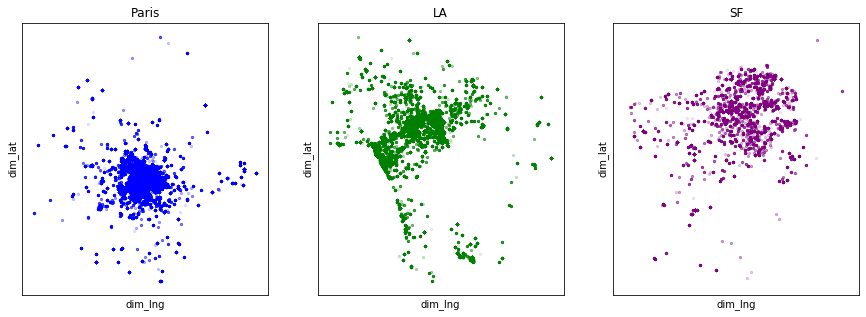

Paris            110304
Los Angeles       51516
San Francisco     17455
Name: dim_market, dtype: int64

In [18]:
## How does GIS info lay out by market?

data_paris = data[data['dim_market'] == 'Paris']
data_la = data[data['dim_market'] == 'Los Angeles']
data_sf = data[data['dim_market'] == 'San Francisco']

fig, axes = plt.subplots(1, 3, figsize=(15,5))
data_paris.plot.scatter(x='dim_lng', y='dim_lat', c='blue',   alpha=0.1, ax = axes[0], s=5)
data_la.plot.scatter(   x='dim_lng', y='dim_lat', c='green',  alpha=0.1, ax = axes[1], s=5)
data_sf.plot.scatter(   x='dim_lng', y='dim_lat', c='purple', alpha=0.1, ax = axes[2], s=5)

for ax, city in zip(axes, ['Paris','LA','SF']):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(city)
    
plt.show()
data['dim_market'].value_counts()

We plan to segment training and test sets by market. Because of the relatively small size of the San Francisco market, we intend to use this as our test set. This design decision means including GIS info is extremely risky, so we remove it now

In [19]:
if 'dim_lng' in data.columns and 'dim_lat' in data.columns:
    data.drop(columns = ['dim_lng', 'dim_lat'], inplace=True)
print(data.shape)

(179275, 27)


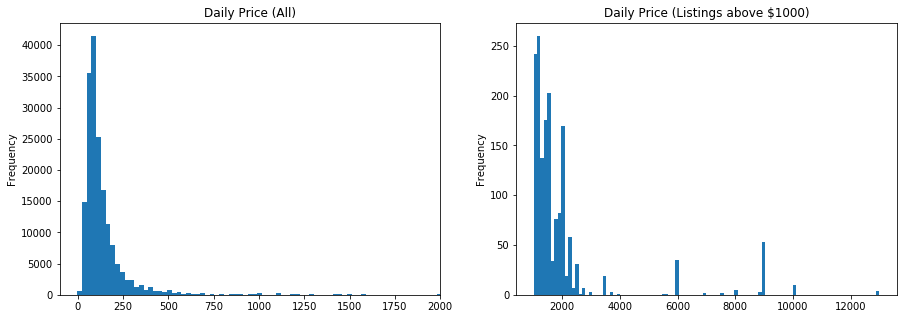

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

data['m_effective_daily_price'].plot.hist(bins=500, alpha=1, ax=axes[0])
high_cost_data = data[data['m_effective_daily_price'] > 1000]
high_cost_data['m_effective_daily_price'].plot.hist(bins=100, alpha=1, ax=axes[1])

axes[0].set_title("Daily Price (All)")
axes[0].set_xlim(-100,2000)
axes[1].set_title("Daily Price (Listings above $1000)")
plt.show()

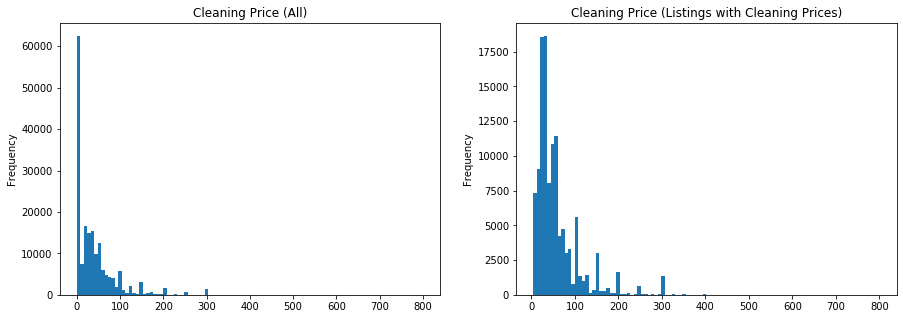

In [21]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

ax = data['m_pricing_cleaning_fee'].plot.hist(bins=100, alpha=1, ax=axes[0])
cleaning_data = data[data['m_pricing_cleaning_fee'] > 0]
ax = cleaning_data['m_pricing_cleaning_fee'].plot.hist(bins=100, alpha=1, ax=axes[1])

axes[0].set_title("Cleaning Price (All)")
axes[1].set_title("Cleaning Price (Listings with Cleaning Prices)")
plt.show()

Text(0.5, 0, 'Room Capacity')

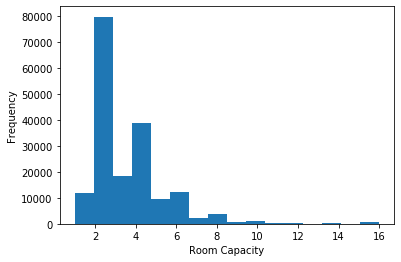

In [22]:
ax = data['dim_person_capacity'].plot.hist(bins=16, alpha=1)
plt.xlabel("Room Capacity")

Text(0.5, 0, 'Total Checkouts')

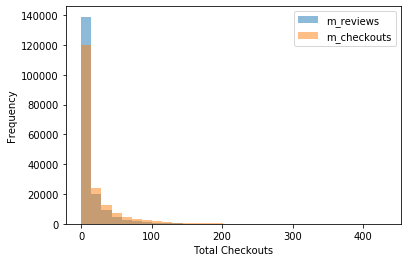

In [23]:
ax = data[['m_reviews','m_checkouts']].plot.hist(bins=30, alpha=0.5)
plt.xlabel("Total Checkouts")

Text(0.5, 0, 'Days Since Last Booking')

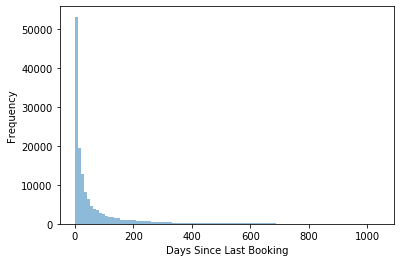

In [24]:
ax = data['days_since_last_booking'].plot.hist(bins=100, alpha=0.5)
plt.xlabel("Days Since Last Booking")

In [25]:
data['dim_room_type'].value_counts()

Entire home/apt    126063
Private room        46494
Shared room          6718
Name: dim_room_type, dtype: int64

In [26]:
data['dim_is_instant_bookable'].value_counts()

False    153013
True      26262
Name: dim_is_instant_bookable, dtype: int64

In [27]:
data['cancel_policy'].value_counts()

5    75193
4    56506
3    47473
8       58
6       39
7        6
Name: cancel_policy, dtype: int64

Text(0.5, 0, 'Image quality')

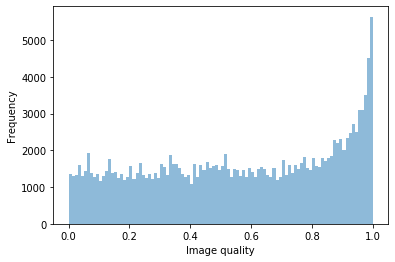

In [28]:
ax = data['image_quality_score'].plot.hist(bins=100, alpha=0.5)
plt.xlabel("Image quality")

Text(0.5, 0, 'Rating')

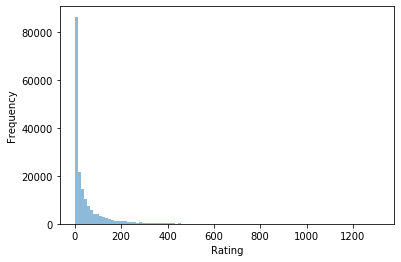

In [29]:
## This feature should be converted into average rating!

ax = data['m_total_overall_rating'].plot.hist(bins=100, alpha=0.5)
plt.xlabel("Rating")

Text(0.5, 0, 'Number of Professional Pictures')

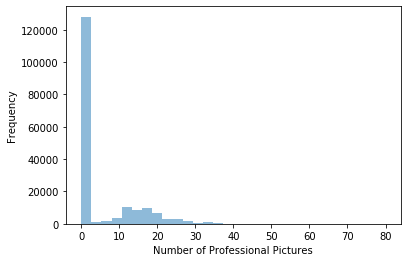

In [30]:
ax = data['m_professional_pictures'].plot.hist(bins=30, alpha=0.5)
plt.xlabel("Number of Professional Pictures")

In [31]:
data['ds_night_day_of_week'].value_counts()

5    26044
6    25912
2    25911
0    25459
3    25458
1    25457
4    25034
Name: ds_night_day_of_week, dtype: int64

Text(0.5, 0, 'Day of the Year')

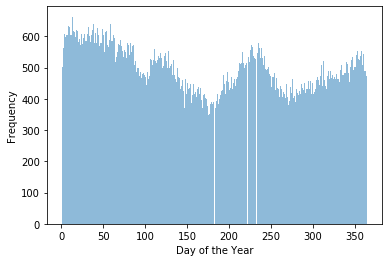

In [32]:
ax = data['ds_night_day_of_year'].plot.hist(bins=365, alpha=0.5)
plt.xlabel("Day of the Year")

Text(0.5, 0, 'Minimum Nights')

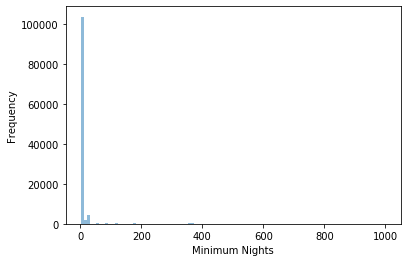

In [33]:
some_min = data[data['m_minimum_nights'] > 1]
ax = some_min['m_minimum_nights'].plot.hist(bins=100, alpha=0.5)
plt.xlabel("Minimum Nights")

Text(0.5, 0, 'Minimum Nights')

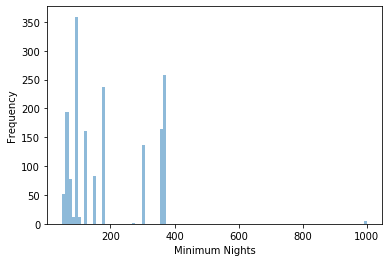

In [34]:
required_min_data = data[data['m_minimum_nights'] > 40]
ax = required_min_data['m_minimum_nights'].plot.hist(bins=100, alpha=0.5)
plt.xlabel("Minimum Nights")

# required_min_data['m_minimum_nights']

## Part 4: Feature Engineering

#### We will primarily deal with correlated variables

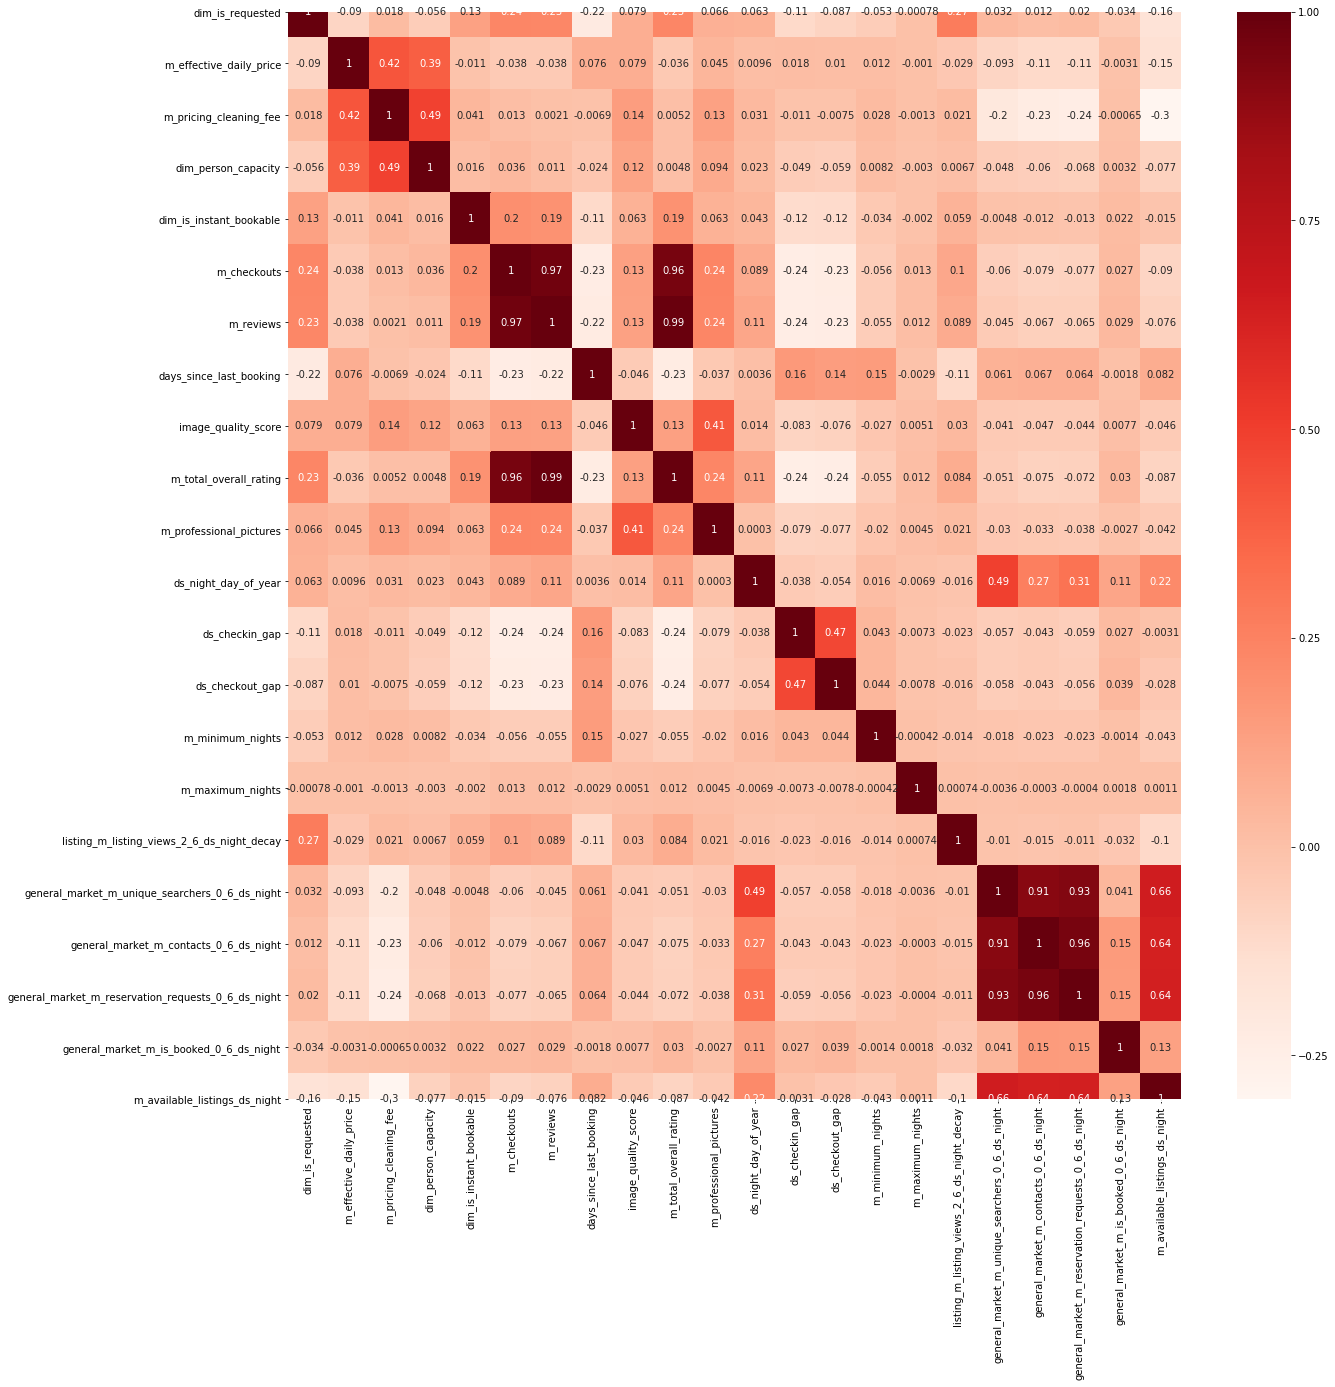

In [35]:
## How correlated is existing data?

plt.figure(figsize=(20,20))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

##### There are several variables that we intuitively expect to be highly correlated. We can proactively handle this by extracting more meaningful (and less correlated) variables from these

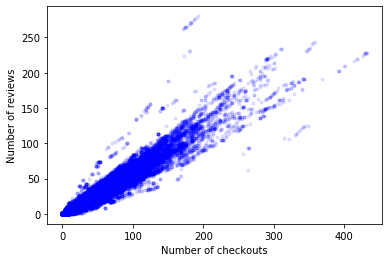

In [36]:
## How correlated are the number of reviews and checkouts?

plt.plot(data['m_checkouts'], data['m_reviews'], 'bo', markersize=3, alpha=0.1)
plt.xlabel('Number of checkouts')
plt.ylabel('Number of reviews')
plt.show()

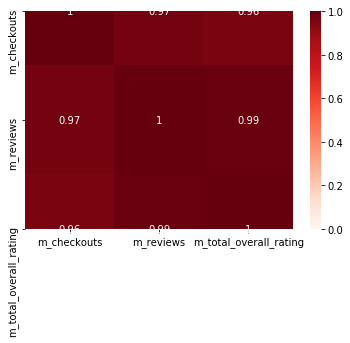

In [37]:
cor = data[['m_checkouts', 'm_reviews', 'm_total_overall_rating']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.show()

Text(0.5, 0, 'Average Rating')

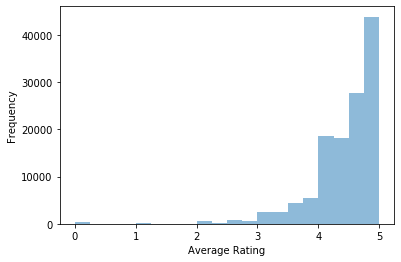

In [38]:
## Replace total overall rating with average overall rating, drop number of reviews

if 'm_total_overall_rating' in data.columns:
    data['m_avg_overall_rating'] = data['m_total_overall_rating'] / data['m_reviews']
    data.drop(columns = ['m_total_overall_rating'], inplace=True)
if 'm_reviews' in data.columns:
    data.drop(columns = ['m_reviews'], inplace=True)

ax = data['m_avg_overall_rating'].plot.hist(bins=20, alpha=0.5)
plt.xlabel("Average Rating")

In [39]:
## This introduces a good amount of nulls for listings that have no reviews:

print("Number of nulls introduced: {}".format(sum(data['m_avg_overall_rating'].isna())))

## We have a few options for dealing with this:
## (1) Leave the nulls, let a decision tree handle it
## (2) Assign an arbitrary value to the nulls, such as a the mean value. This should resemble the market's Bayesians
## (3) Fancy--Impute values based on existing data. For this, we would probably not include number of reviews as a predictor

Number of nulls introduced: 53501


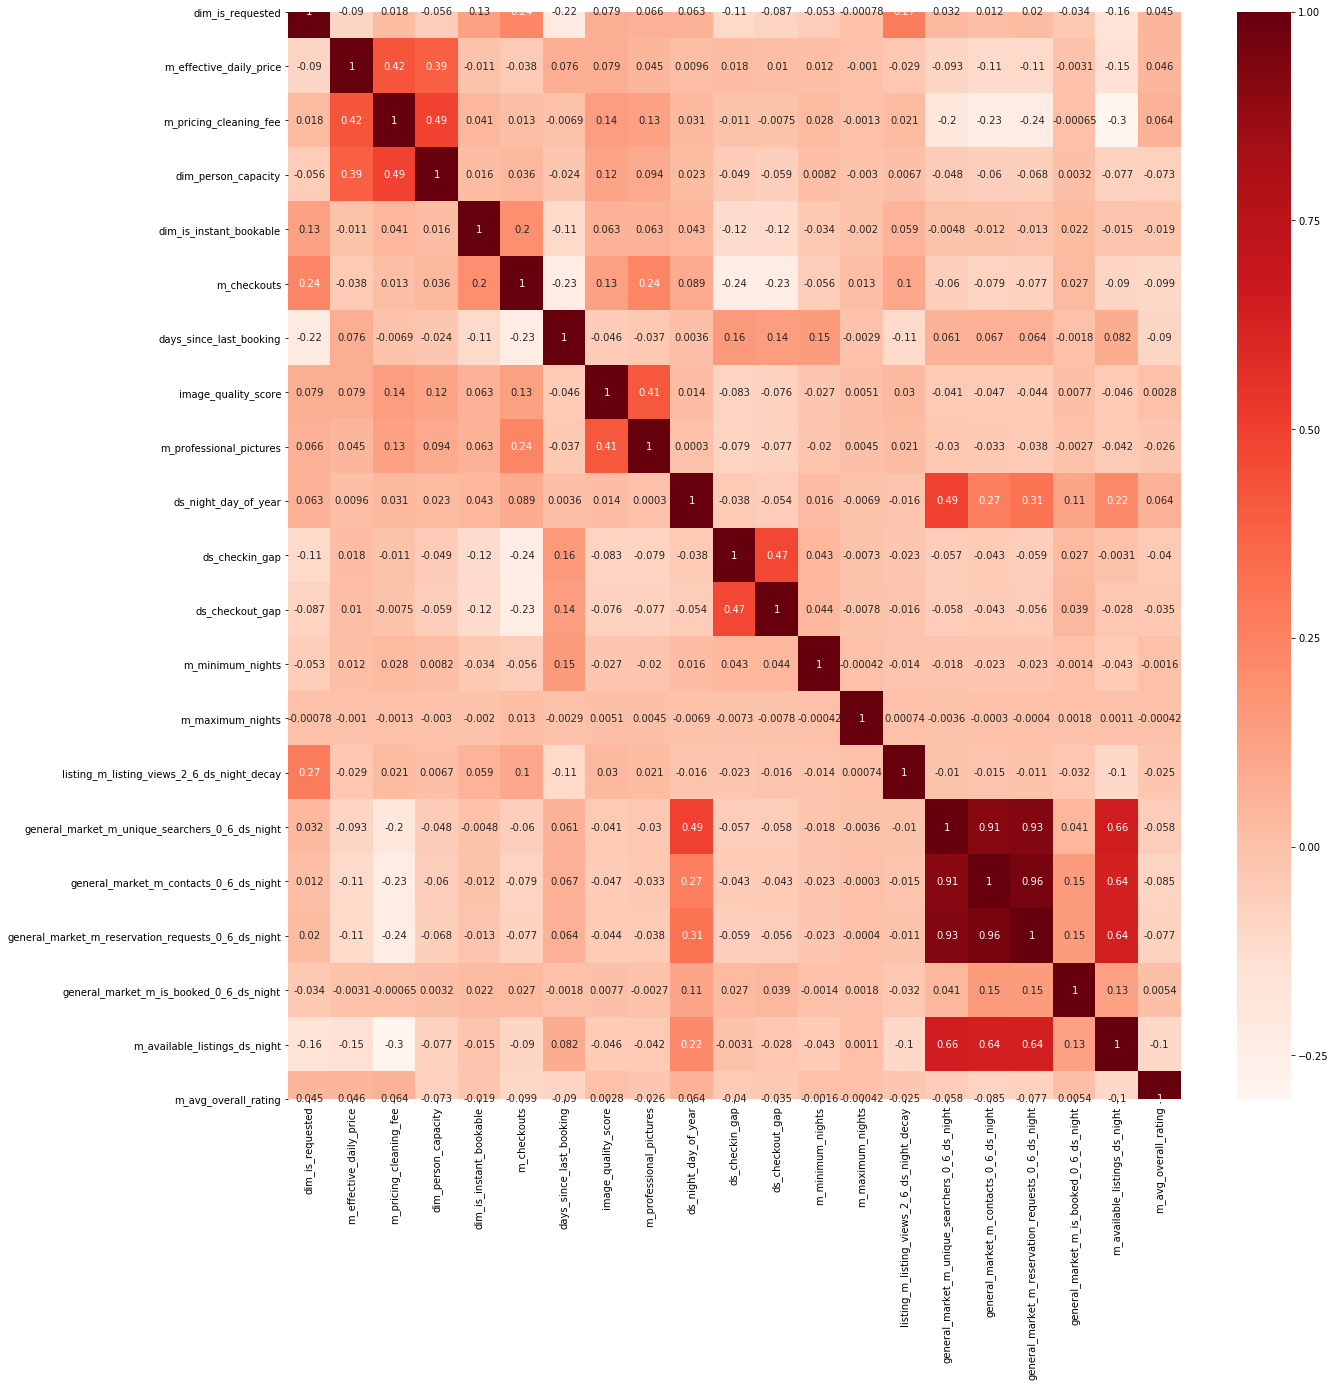

In [40]:
plt.figure(figsize=(20,20))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [43]:
## The average number of searches, contacts, and requests for the market on a night are highly correlated.
## We can reaosnably get by with only one of these three variables

if 'general_market_m_contacts_0_6_ds_night' in data.columns and 'general_market_m_reservation_requests_0_6_ds_night' in data.columns:
    data.drop(columns = ['general_market_m_contacts_0_6_ds_night',
                         'general_market_m_reservation_requests_0_6_ds_night'], 
              inplace=True)

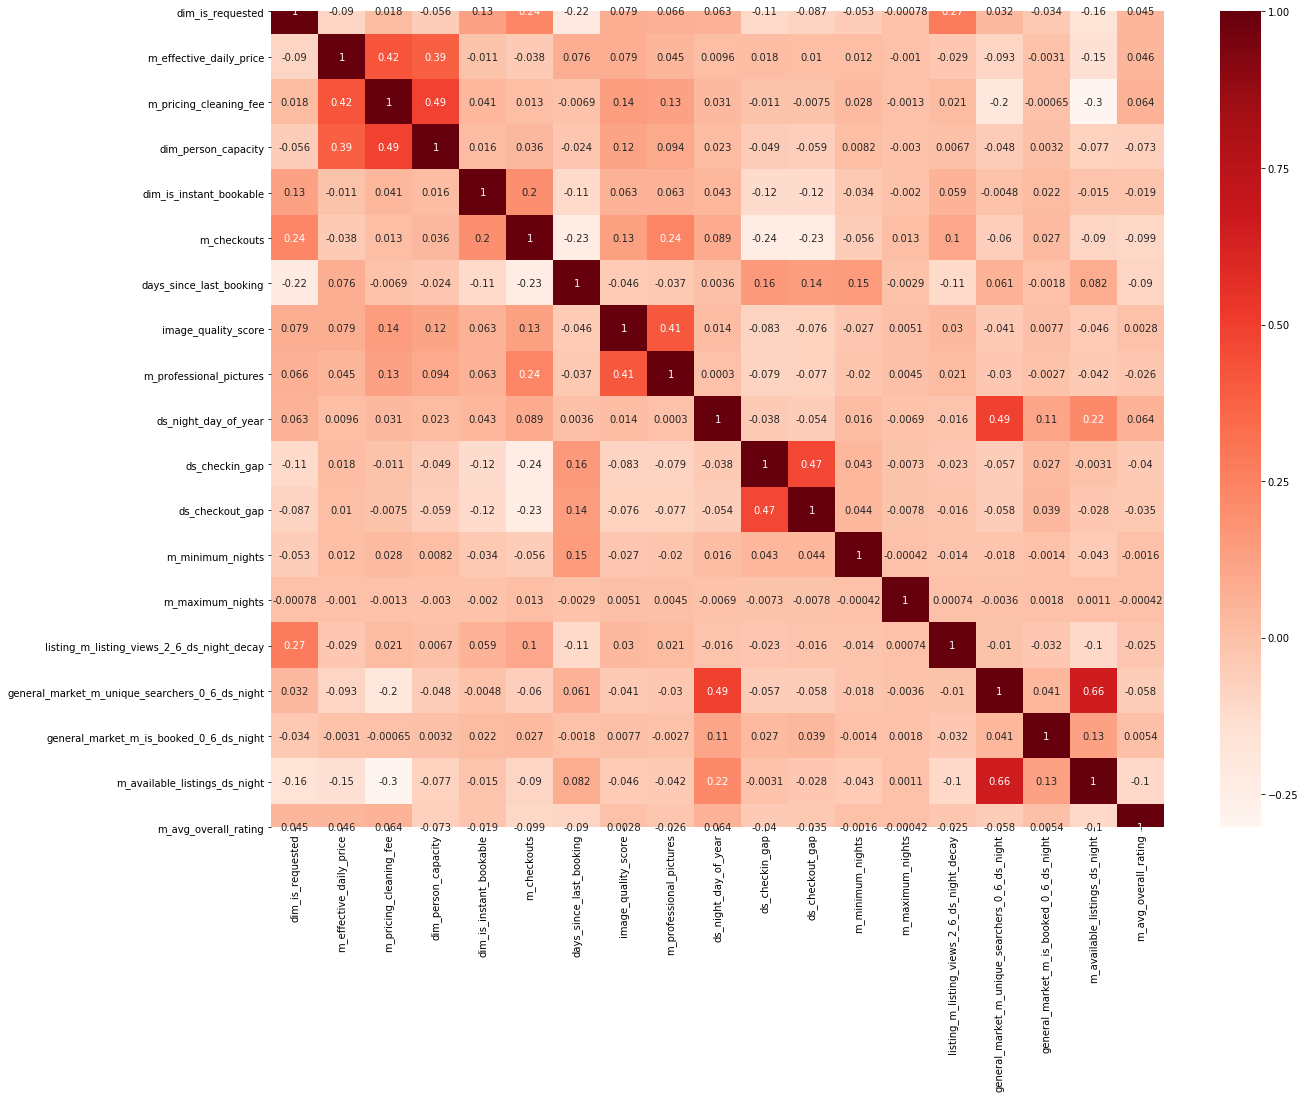

In [45]:
plt.figure(figsize=(20,15))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Part 4.5: Scaling Down Data
#### How much can we sample down our data before it has an impact on the qualitative distribution?

In [46]:
## Split data into training and test data sets

train_data = data[data['dim_market'] != 'San Francisco']
test_data  = data[data['dim_market'] == 'San Francisco']
print(train_data.shape, test_data.shape)

(161820, 24) (17455, 24)


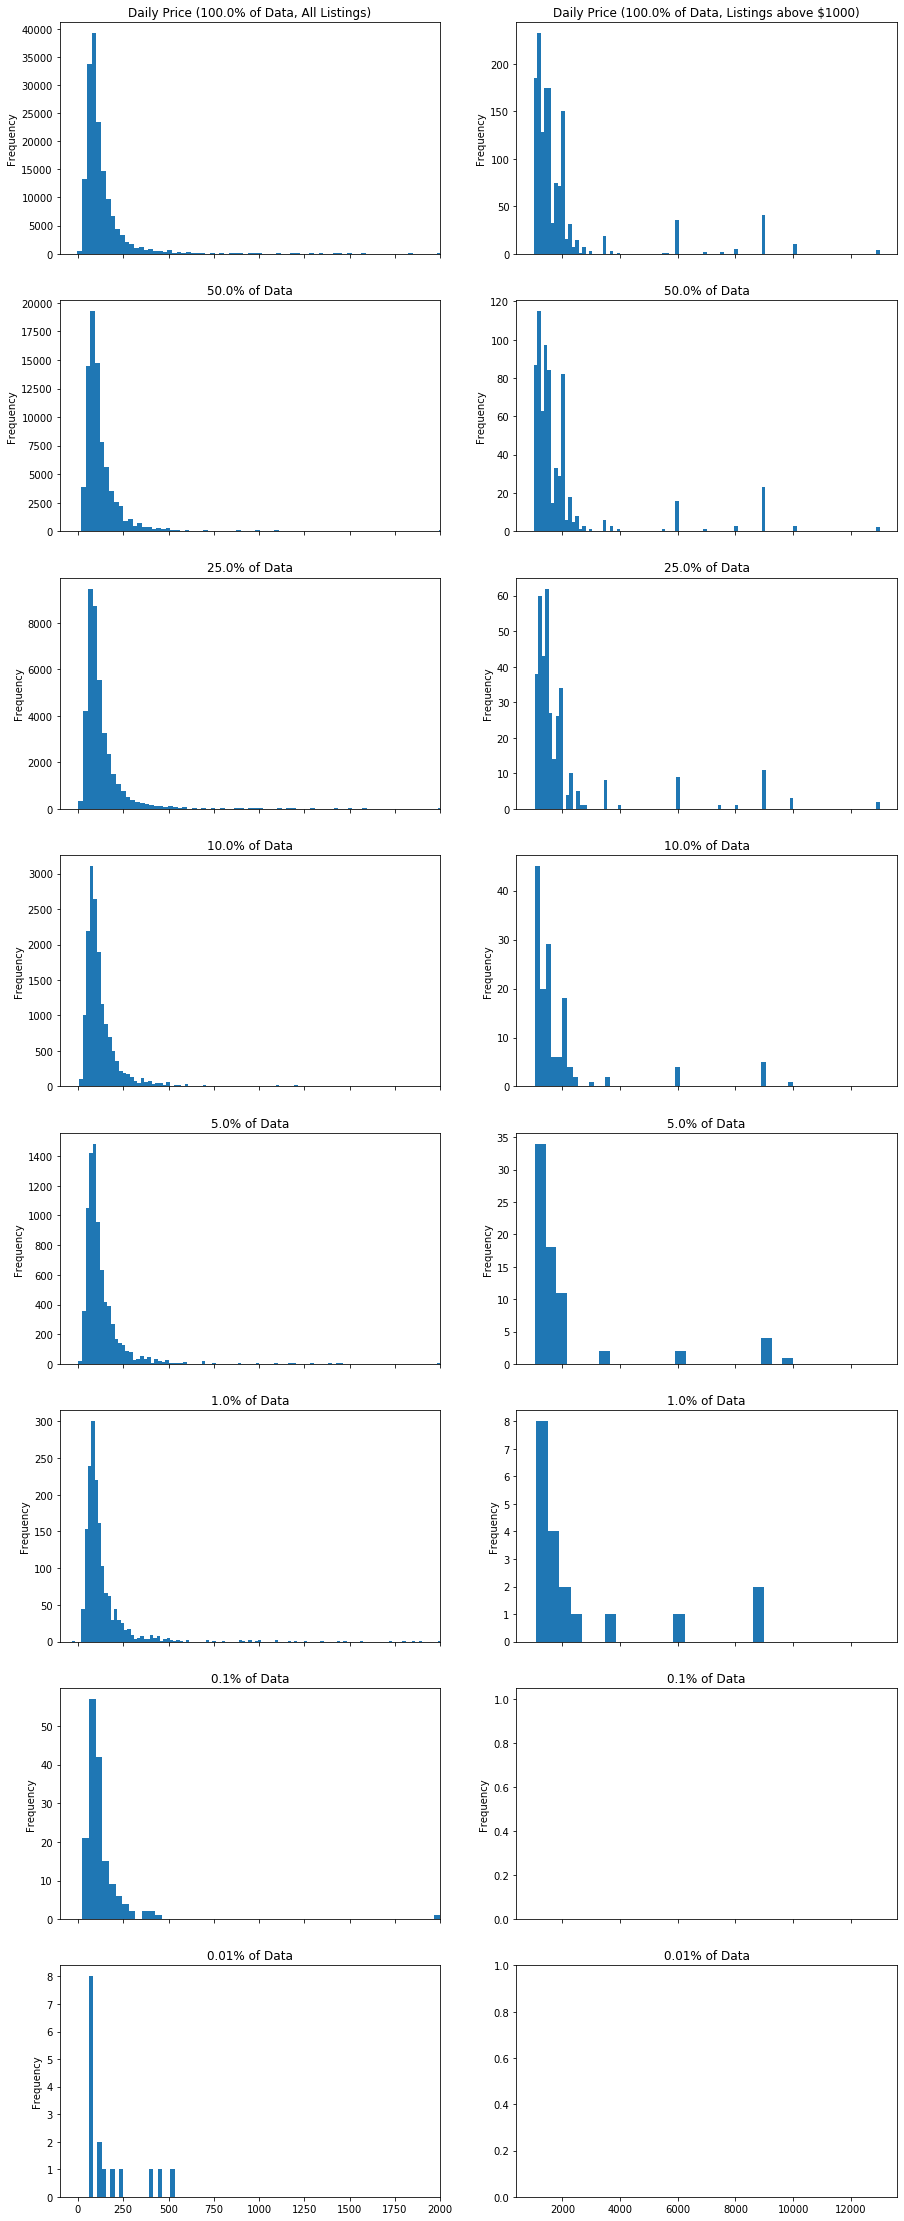

In [47]:
## Examine the distribution of daily listing costs as we scale down the sample size

def bin_count(nData, max_bins=500, min_bins=20):
    return min(max_bins, max(min_bins, round(nData/3)))

scales = [1.0, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]

fig, axes = plt.subplots(len(scales), 2, figsize=(15,5*len(scales)), sharex='col')
first_row = True

for scale,ax_row in zip(scales,axes):
    ## Obtain a sampling of the data as determined by the scale
    dsample = train_data.sample(frac = scale)
    dsample_high = dsample[dsample['m_effective_daily_price'] > 1000]
    nSample = dsample.shape[0]
    nSample_high = dsample_high.shape[0]
    
    ## Create complete and high-value-only histograms
    dsample['m_effective_daily_price'].plot.hist(bins=bin_count(nSample), alpha=1, ax=ax_row[0])
    if nSample_high > 0:
        dsample_high['m_effective_daily_price'].plot.hist(bins=bin_count(nSample_high, max_bins=100), 
                                                          alpha=1, ax=ax_row[1])

    ## Plot formatting
    if first_row:
        ax_row[0].set_title("Daily Price ({}% of Data, All Listings)".format(scale*100))
        ax_row[1].set_title("Daily Price ({}% of Data, Listings above $1000)".format(scale*100))
        ax_row[0].set_xlim(-100,2000)
        first_row = False
    else:
        ax_row[0].set_title("{}% of Data".format(scale*100))
        ax_row[1].set_title("{}% of Data".format(scale*100))

plt.show()

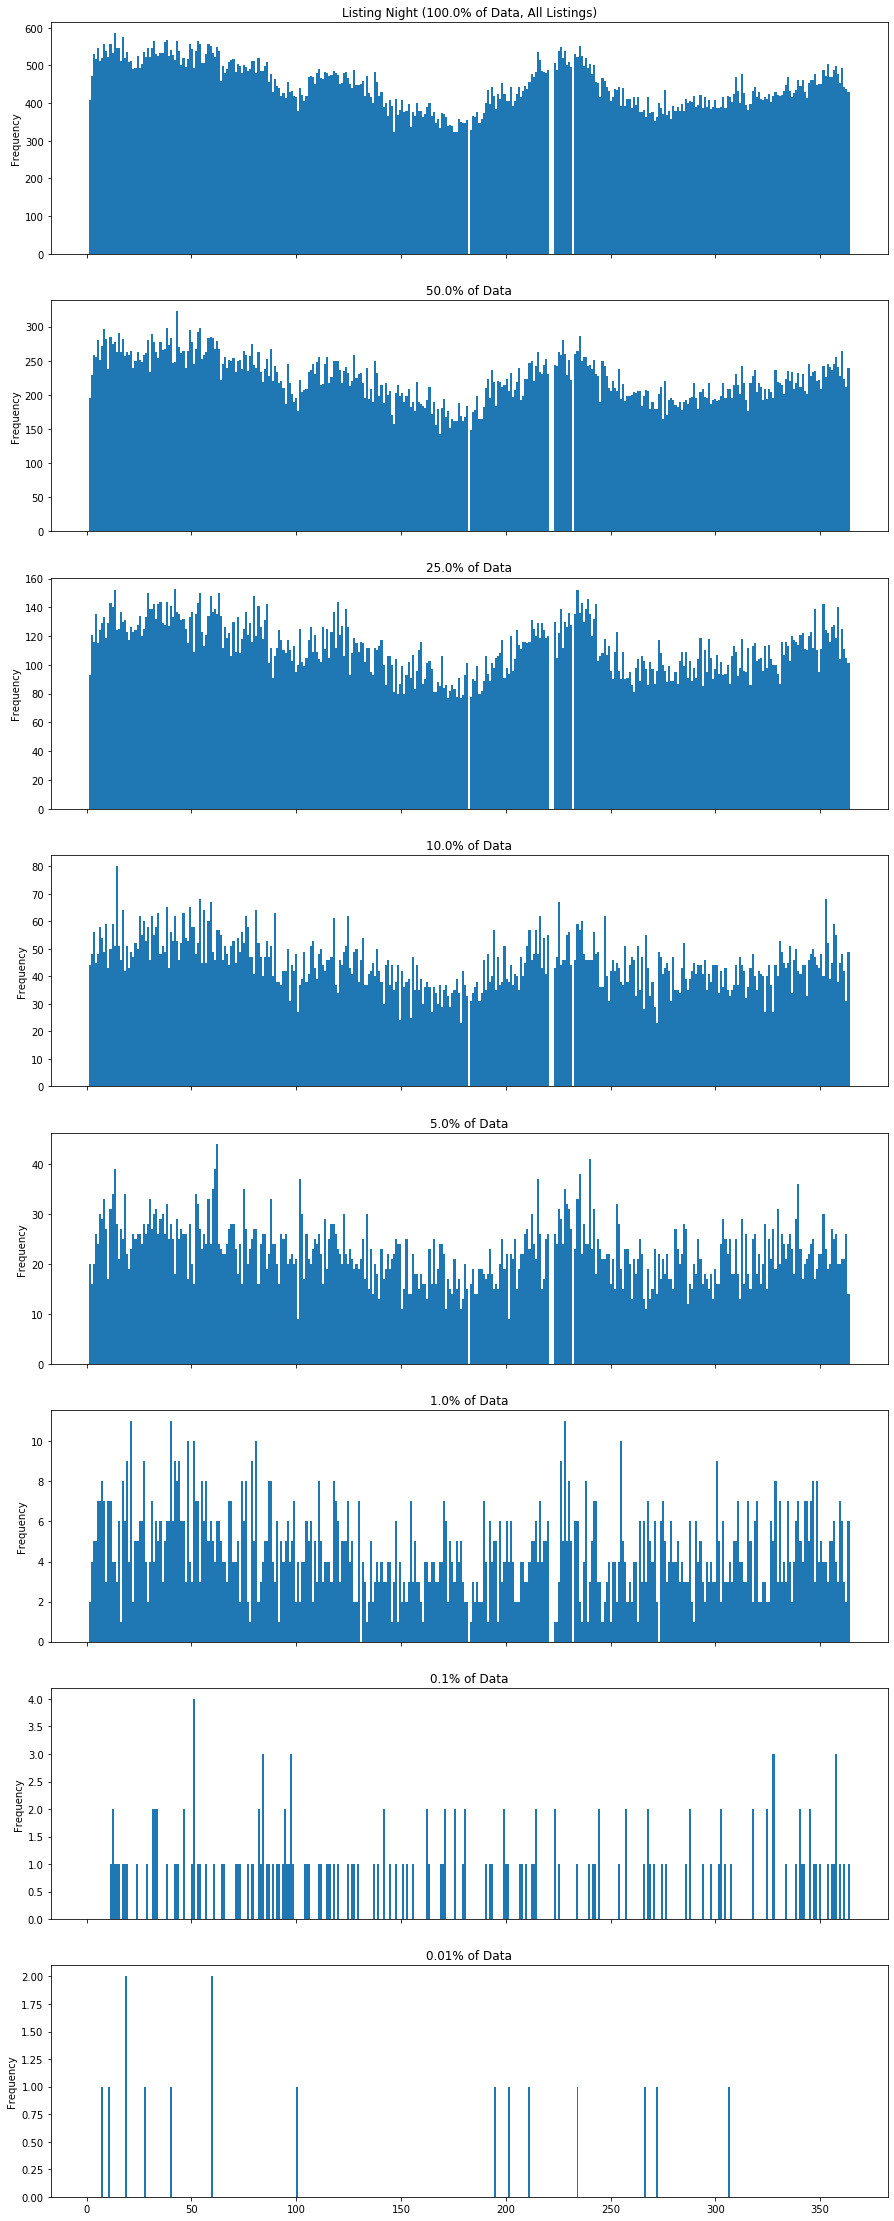

In [48]:
scales = [1.0, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]

fig, axes = plt.subplots(len(scales), 1, figsize=(15,5*len(scales)), sharex='col')
first_row = True

for scale,axis in zip(scales,axes):
    ## Obtain a sampling of the data as determined by the scale
    dsample = train_data.sample(frac = scale)
    nSample = dsample.shape[0]
    
    ## Create histogram
    dsample['ds_night_day_of_year'].plot.hist(bins=365, alpha=1, ax=axis)

    ## Plot formatting
    if first_row:
        axis.set_title("Listing Night ({}% of Data, All Listings)".format(scale*100))
        first_row = False
    else:
        axis.set_title("{}% of Data".format(scale*100))

plt.show()